In [1]:
from copy import deepcopy

import torch
import numpy as np
import matplotlib.pyplot as plt

from arithmetic_lm.model import UniversalTransformer, generate
from arithmetic_lm.tokenizer import CharTokenizer
from arithmetic_lm.formatting import format_line
from arithmetic_lm.constants import PLOTS_DIR

import warnings

warnings.filterwarnings("ignore")

In [2]:
ckpt_path = "../checkpoints/addition-1-9-digit-pad/ut_1steps_384embd_2head/step=15500-train_loss=0.0108-val_loss=4.6606.ckpt"

In [3]:
tokenizer = CharTokenizer()

In [5]:
# load model
ckpt = torch.load(ckpt_path, map_location="mps")
model = UniversalTransformer(
    **ckpt["hyper_parameters"]["model_hparams"], vocab_size=tokenizer.vocab_size
)
# state dict has a prefix "model." in the key names
model.load_state_dict({k[6:]: v for k, v in ckpt["state_dict"].items()})
model.eval()

UniversalTransformer(
  (embedding): Embedding(100, 384, padding_idx=99)
  (coord_encoder): CoordinateEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder_layer): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=384, out_features=384, bias=True)
    )
    (linear1): Linear(in_features=384, out_features=1536, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=1536, out_features=384, bias=True)
    (norm1): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
  (decoder_layer): TransformerDecoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=384, out_features=384, bias=True)
    )
    (multihead_attn): MultiheadAttention(
      (out_proj): 

In [16]:
def predict_hooked(
    model: torch.nn.Module,
    prompt: torch.Tensor,
    decoder_prompt: torch.Tensor,
    module_name: str,
    pre_hook: callable = None,
    hook: callable = None,
) -> str:
    hooked_model = deepcopy(model)
    hooked_model.eval()

    module = eval(f"hooked_model.{module_name}", {"hooked_model": hooked_model})

    if pre_hook is not None:
        module.register_forward_pre_hook(pre_hook, with_kwargs=True)

    if hook is not None:
        module.register_forward_hook(hook)

    logits = hooked_model(source=prompt, target=decoder_prompt)[0, -1, :]
    pred_token_id, pred_token_logit = logits.argmax().item(), logits.max().item()
    pred_token_str = tokenizer.decode([pred_token_id])

    # delete hooked model
    del hooked_model

    return pred_token_str, pred_token_logit

prompt: '\n$0001239999+0000956959'
true_ans: 2196958
decoder prompt: =0000
pred_token_str: 2
pred_token_logit: 22.78687858581543
attn_map.shape: torch.Size([2, 23, 23])


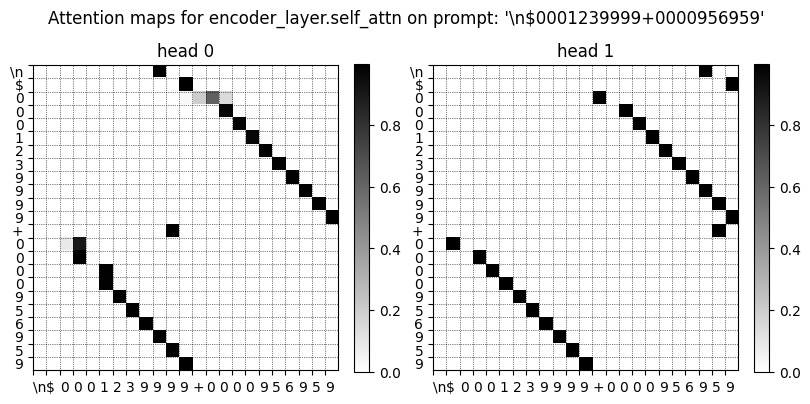

In [74]:
a = 1239999
b = 956959
pad_zeros = 10
pad_ans_zeros = 11
module_name = "encoder_layer.self_attn"

prompt_str = f"\n${str(a).zfill(pad_zeros)}+{str(b).zfill(pad_zeros)}"
print("prompt:", repr(prompt_str))
true_ans = a + b
print("true_ans:", true_ans)

# "fast-forward" to the first digit
decoder_prompt_str = "=" + "0" * (pad_ans_zeros - len(str(true_ans)))

# just before first actual digit
decoder_prompt = torch.tensor([tokenizer.encode(decoder_prompt_str)])
print(f"decoder prompt:", decoder_prompt_str)

prompt = tokenizer.encode(prompt_str)
prompt = torch.tensor([prompt])

attn_maps = {}


def get_attention_map(name):
    def hook(module, inputs, output):
        # nn.MultiheadAttention outputs 2 tensors by default:
        # - the output of the last linear transformation with shape [bs, tgt_len, embed_dim]
        # - the attention map (weights) with shape [bs, n_heads, tgt_len, src_len]
        attn_maps[name] = output[1].detach()

    return hook


def set_attn_kwargs_prehook(module, args, kwargs):
    """
    make sure self.attn module is called with need_weights=True and
    average_attn_weights=False so that we get per-head attention weights
    """
    kwargs["need_weights"] = True
    kwargs["average_attn_weights"] = False
    return args, kwargs


# get attention map from encoder_layer.self_attn
pred_token_str, pred_token_logit = predict_hooked(
    model,
    prompt,
    decoder_prompt,
    module_name=module_name,
    pre_hook=set_attn_kwargs_prehook,
    hook=get_attention_map(module_name),
)

print("pred_token_str:", pred_token_str)
print("pred_token_logit:", pred_token_logit)

attn_map = attn_maps[module_name].squeeze(0)
print("attn_map.shape:", attn_map.shape)
n_heads = attn_map.shape[0]

# plot attention maps
fig, axs = plt.subplots(1, n_heads, layout="constrained", figsize=(8, 4))
ticks = list(prompt_str)
ticks[0] = "\\n" if ticks[0] == "\n" else ticks[0]

for i, ax in enumerate(axs):
    ax.imshow(attn_map[i], cmap="binary", interpolation="none")
    ax.set_yticks(np.arange(len(ticks)) - 0.5)
    ax.set_yticklabels(ticks, va="top")
    ax.set_xticks(np.arange(len(ticks)) - 0.5)
    ax.set_xticklabels(ticks, ha="left")
    ax.set_title(f"head {i}")
    # colorbar
    cbar = ax.figure.colorbar(ax.images[0], ax=ax, shrink=0.85)
    # grid
    ax.grid(which="both", color="k", linestyle=":", linewidth=0.5)

fig.suptitle(f"Attention maps for {module_name} on prompt: {repr(prompt_str)}")
plt.savefig(PLOTS_DIR / "exp8_encoder_attention_maps.png")
plt.show()